# 测试Modified Nodal Analysis计算结果

In [1]:
import numpy as np
import time
import seaborn as sns

#### 描述阵列参数

In [2]:
# size of subarray
xbar_row = 128
xbar_column = 128

# resistance of metal line
r_row = 2
r_column = 2

Rm_max = 50e3
Rm_min = 10e3
Rm_off = 10e9
# V_d2d,V_c2c，non-linearity，weight bit待添加
# ADC/DAC 待添加

In [7]:
# 随机生成权重矩阵并保存
# w = np.random.normal(0,0.3,(xbar_row,xbar_column))
# # w = np.ones(xbar_row*xbar_column).reshape(xbar_row,xbar_column)

# w = np.where(w>1,1,w)
# w = np.where(w<-1,-1,w)
# np.save('./w.npy',w)

#### 权重矩阵生成 W2G

In [3]:
w = np.load('./w.npy')
G_p = np.where(w>=0,w*(1/Rm_min-1/Rm_max)+1/Rm_max,1/Rm_max)
G_n = np.where(w<0,-w*(1/Rm_min-1/Rm_max)+1/Rm_max,1/Rm_max)
Vin = np.ones(xbar_row)*300  #####测试用例中输入全1


In [7]:
#双电源方案
Gmix = np.hstack((G_p,G_n)).reshape(2*xbar_row,xbar_column)

print(G_p)
print(G_n)
print(Gmix[:xbar_row,:].shape)

[[2.36575795e-05 2.00000000e-05 2.00000000e-05 ... 6.06881006e-05
  2.00000000e-05 2.00000000e-05]
 [7.26618490e-05 4.24338595e-05 4.25624833e-05 ... 2.00000000e-05
  5.42321059e-05 3.31914387e-05]
 [2.00000000e-05 2.17230905e-05 2.00000000e-05 ... 2.75309556e-05
  2.00000000e-05 2.73531510e-05]
 ...
 [2.00000000e-05 6.33794669e-05 2.00000000e-05 ... 2.00000000e-05
  2.75137641e-05 2.00000000e-05]
 [2.00000000e-05 4.98454357e-05 2.89138803e-05 ... 2.00000000e-05
  7.63438318e-05 2.00000000e-05]
 [3.10984222e-05 4.43088824e-05 3.38440907e-05 ... 2.00000000e-05
  3.36599653e-05 2.00000000e-05]]
[[2.00000000e-05 2.13530869e-05 5.68116122e-05 ... 2.00000000e-05
  5.72106678e-05 3.87232425e-05]
 [2.00000000e-05 2.00000000e-05 2.00000000e-05 ... 4.13085373e-05
  2.00000000e-05 2.00000000e-05]
 [2.11819951e-05 2.00000000e-05 5.29381555e-05 ... 2.00000000e-05
  2.53119941e-05 2.00000000e-05]
 ...
 [3.38462358e-05 2.00000000e-05 2.66149616e-05 ... 6.14350872e-05
  2.00000000e-05 6.71675272e-05]

### 根据MNA算法生成矩阵 
**G=尺寸(xbar_row\*xbar_column\*2+xbar_row)方阵** 
<br> 
**B=尺寸(xbar_row\*xbar_column\*2+xbar_row,xbar_row)矩阵** 
<br>
**C=尺寸(xbar_row，xbar_row\*xbar_column\*2+xbar_row)矩阵  C = B.T** 
<br>
**D=尺寸(xbar_row,xbar_row)方阵** 
<br>
https://lpsa.swarthmore.edu/Systems/Electrical/mna/MNA3.html
<br><br>
**上节点数xbar_row\*(xbar_column+1)**
<br>
**下节点数xbar_row\*xbar_column**
<br>
**节点排序：上节点逐行➡下节点逐行➡电源输入节点**

In [8]:
# G_target = G_p  #######仅供测试使用
G_target = Gmix[:xbar_row,:]
G = np.zeros((xbar_row*xbar_column*2+xbar_row,xbar_row*xbar_column*2+xbar_row))
print(G[0][0])
for i in range(xbar_row*xbar_column):
    #上节点第一列  
    if i%xbar_column==0:
        G[i][i] = 2/r_row + G_target[i//xbar_column][0]
        G[i][i+1] = -1/r_row
        G[i][i//xbar_column+xbar_row*xbar_column*2] = -1/r_row  ######此处可以考虑驱动的电阻
        G[i][i+xbar_row*xbar_column] = -G_target[i//xbar_column][0]
    #上节点最后一列
    elif i%xbar_column==(xbar_column-1):
        G[i][i] = 1/r_row + G_target[i//xbar_column][xbar_column-1]
        G[i][i-1] = -1/r_row
        G[i][i+xbar_row*xbar_column] = -G_target[i//xbar_column][xbar_column-1]
    #上节点非首尾列
    else:
        G[i][i] = 2/r_row + G_target[i//xbar_column][i%xbar_column]
        G[i][i-1] = -1/r_row
        G[i][i+1] = -1/r_row
        G[i][i+xbar_row*xbar_column] = -G_target[i//xbar_column][i%xbar_column]

######下节点        
for i in range(xbar_row*xbar_column,xbar_row*xbar_column*2):
    #下节点第一行
    if i<(xbar_row*xbar_column+xbar_column):
        G[i][i] = 1/r_column + G_target[0][i-xbar_row*xbar_column]
        G[i][i-xbar_row*xbar_column] = -G_target[0][i-xbar_row*xbar_column]
        G[i][i+xbar_column] = -1/r_column
    #下节点最后一行
    elif i>=(xbar_row*xbar_column*2-xbar_column):
        G[i][i] = 2/r_column + G_target[xbar_row-1][i+xbar_column-xbar_row*xbar_column*2] #######此处可考虑读出电路带来的负载电阻
        G[i][i-xbar_column] = -1/r_column
        G[i][i-xbar_row*xbar_column] = -G_target[xbar_row-1][i+xbar_column-xbar_row*xbar_column*2]
    #下节点非首尾行
    else:
        G[i][i] = 2/r_column + G_target[(i-xbar_row*xbar_column)//xbar_column][(i-xbar_row*xbar_column)%xbar_column]
        G[i][i-xbar_row*xbar_column] = -G_target[(i-xbar_row*xbar_column)//xbar_column][(i-xbar_row*xbar_column)%xbar_column]
        G[i][i-xbar_column] = -1/r_column
        G[i][i+xbar_column] = -1/r_column

        
    
#####电源输入节点
for i in range(xbar_row*xbar_column*2,xbar_row*xbar_column*2+xbar_row):
    G[i][i] = 1/r_row  ######此处可以考虑驱动的电阻
    G[i][(i-xbar_row*xbar_column*2)*xbar_column] = -1/r_row  ######可考虑驱动的电阻                  
print(G[0][0])        

0.0
1.0000236575795156


In [16]:
# Vin = np.random.randint(1,300,xbar_row) #######测试不同Vin影响
# print(Vin)
# Vin = np.ones(xbar_row)
# 双电源输入
a = np.ones(xbar_row)
b = -a
c = np.vstack((a,b)).T
Vin = c.reshape(2*xbar_row)[:xbar_row]
print(Vin)
print(Vin.shape)

[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.]
(128,)


### B,C,D矩阵生成
**B矩阵每一列表示一个独立输入电压源**<br>
**电极正极对应节点(行)为1，负极对应节点(行)为-1**<br>
**RRAM阵列中电压源有一端接地**<br>
**C为B的转置**<br>
**D为0方阵**<br>
**Ax = z**<br>
**<font color = red>ndarray中一维数组只有列向量</font>**

In [17]:
B = np.zeros((xbar_row*xbar_column*2+xbar_row,xbar_row))
for i in range(xbar_row):
    B[i+xbar_row*xbar_column*2][i] = 1  #######单电源输入情况
C = np.transpose(B) 
D = np.zeros((xbar_row,xbar_row))
temp1 = np.hstack((G,B))
temp2 = np.hstack((C,D))
A = np.vstack((temp1,temp2))
print(A.shape)
z = np.zeros((xbar_row*xbar_column*2+xbar_row))
z = np.hstack((z,Vin))
print(z[-xbar_row:])



(33024, 33024)
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.]


In [18]:
start = time.time()
# 求解节点电压和每列输出电流
x = np.linalg.solve(A,z)
end = time.time()
print(start,end,end-start)

1679549724.3410687 1679549780.8841193 56.54305052757263


In [19]:
# upnode voltage
print(x[:xbar_row*xbar_column].reshape(xbar_row,xbar_column))
# downnode voltage
print(x[xbar_row*xbar_column:xbar_row*xbar_column*2].reshape(xbar_row,xbar_column))
# input node voltage
print(x[xbar_row*xbar_column*2:xbar_row*xbar_column*2+xbar_row])
# input current of voltage source
print(x[xbar_row*xbar_column*2+xbar_row:])


[[ 0.99423276  0.98851355  0.98283416 ...  0.65246222  0.65241125
   0.65238567]
 [-0.9939235  -0.98788592 -0.98189022 ... -0.62697363 -0.62685035
  -0.62680082]
 [ 0.99424488  0.98863729  0.9831142  ...  0.65929383  0.65918135
   0.65913844]
 ...
 [-0.99420166 -0.9885024  -0.98285424 ... -0.67136487 -0.67131113
  -0.67128425]
 [ 0.9944303   0.98892141  0.98346699 ...  0.65777075  0.65770008
   0.65765572]
 [-0.99434146 -0.98872268 -0.98314344 ... -0.65569247 -0.65561026
  -0.65558403]]
[[-2.08723462e-02 -7.03994811e-03  6.09318624e-03 ...  1.09086393e-02
   1.76532407e-02  1.27775102e-02]
 [-2.09203760e-02 -7.07977025e-03  6.05411660e-03 ...  1.08307699e-02
   1.76278504e-02  1.27519259e-02]
 [-2.09294858e-02 -7.07770591e-03  6.12730039e-03 ...  1.07784128e-02
   1.76762022e-02  1.27758727e-02]
 ...
 [-4.67437238e-04 -1.15744729e-03  5.51927747e-04 ... -5.58949327e-04
   2.61069711e-04  6.35469002e-04]
 [-2.84342120e-04 -7.48493775e-04  3.65548740e-04 ... -3.49164043e-04
   1.72922866

In [21]:
up_node = (x[:xbar_row*xbar_column]).reshape(xbar_row,xbar_column)
down_node = (x[xbar_row*xbar_column:xbar_row*xbar_column*2]).reshape(xbar_row,xbar_column)


V_rram = (up_node-down_node).reshape(xbar_row,xbar_column)
V_rram = np.abs(V_rram)
# print(V_rram[0][:10])

# vin_ideal = np.zeros((xbar_row,xbar_column))
# for i in range(xbar_row):
#     vin_ideal[i][:] = Vin[i]
    
# G_p_eqv = G_p*V_rram/vin_ideal     #########由于线阻，实际等效电导要小于理想电导
# print(G_p[0][0],G_p_eqv[0][0])
# i_real = (V_rram*G_p).sum(axis=0)
# i_eqv = (vin_ideal*G_p_eqv).sum(axis=0)
# print('\n')
# print(i_real)
# print(i_eqv)
# print('\n Iout of each column')
# print(x[xbar_row*xbar_column*2-xbar_column:xbar_row*xbar_column*2]/r_column)
print(V_rram)
# np.save('normal_case_vrram_2ou_128.npy',V_rram)
# np.save('normal_case_up_node_2ou_128.npy',up_node)
# np.save('normal_case_down_node_2ou_128.npy',down_node)

np.save('2source_case_vrram_2ou_128.npy',V_rram)
np.save('2source_case_up_node_2ou_128.npy',np.abs(up_node))
np.save('2source_case_down_node_2ou_128.npy',down_node)

[[1.01510511 0.9955535  0.97674098 ... 0.64155359 0.63475801 0.63960816]
 [0.97300312 0.98080615 0.98794434 ... 0.6378044  0.6444782  0.63955275]
 [1.01517437 0.995715   0.9769869  ... 0.64851542 0.64150514 0.64636257]
 ...
 [0.99373422 0.98734495 0.98340617 ... 0.67080592 0.6715722  0.67191972]
 [0.99471464 0.9896699  0.98310144 ... 0.65811991 0.65752716 0.65721124]
 [0.9941794  0.98832867 0.98328329 ... 0.65550477 0.65566874 0.65579315]]


In [33]:
G_p_eqv_all1 = G_p_eqv
print(G_p)
print('\n')
print(G_p_eqv_all1)

[[3.53708647e-05 2.00000000e-05 2.00000000e-05 ... 2.00000000e-05
  2.00000000e-05 2.00000000e-05]
 [2.57531938e-05 2.00000000e-05 2.00000000e-05 ... 2.00000000e-05
  2.74761830e-05 2.00000000e-05]
 [3.17003584e-05 2.00000000e-05 2.00000000e-05 ... 2.00000000e-05
  3.10051132e-05 2.00000000e-05]
 ...
 [6.28237890e-05 3.31714359e-05 2.00000000e-05 ... 4.16852731e-05
  2.00000000e-05 2.00000000e-05]
 [2.00000000e-05 2.00000000e-05 2.00000000e-05 ... 2.00000000e-05
  2.00000000e-05 3.59776092e-05]
 [4.77612307e-05 4.74808983e-05 2.39355406e-05 ... 2.00000000e-05
  2.00000000e-05 4.03160619e-05]]


[[3.52541439e-05 1.99413289e-05 1.99473761e-05 ... 1.98998015e-05
  1.99069843e-05 1.99064864e-05]
 [2.56678700e-05 1.99405956e-05 1.99462259e-05 ... 1.98916671e-05
  2.73371874e-05 1.98983268e-05]
 [3.15963376e-05 1.99416075e-05 1.99476861e-05 ... 1.99024780e-05
  3.08650457e-05 1.99091257e-05]
 ...
 [6.27787357e-05 3.31470021e-05 1.99834947e-05 ... 4.15737728e-05
  1.99473540e-05 1.99469643e-0

In [34]:
# G_p_eqv2 = G_p_eqv

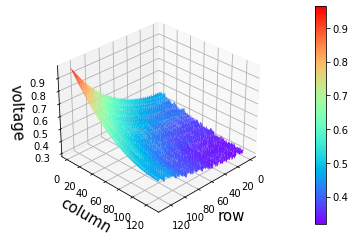

In [12]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')

x = np.arange(1,129)
y = np.arange(1,129)
xx,yy = np.meshgrid(x,y)

surf = ax1.plot_surface(xx,yy,V_rram.T,cmap = 'rainbow')
ax1.set_xlabel('row',fontsize = 15)
ax1.set_ylabel('column',fontsize = 15)
ax1.set_zlabel('voltage',fontsize = 15)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tick_params(labelsize=10)
ax1.view_init(elev = 30,azim = 45)
# ax1.set_zlim(0,2)
fig.colorbar(surf,pad=0.15)


# plt.savefig('./down_node_voltage.jpg')
plt.show()



In [36]:
print(up_node.reshape(32,32))

[[299.95800801 299.91781397 299.87863695 ... 299.33235483 299.33032434
  299.32930911]
 [299.95224376 299.90579659 299.86036638 ... 299.20932397 299.20691496
  299.20590015]
 [299.95866515 299.91894171 299.8802353  ... 299.36945751 299.36686803
  299.36585266]
 ...
 [299.95667796 299.91655763 299.8781278  ... 299.34173859 299.33970398
  299.33868669]
 [299.95227053 299.90556051 299.85986985 ... 299.19974644 299.19690009
  299.19507072]
 [299.94901042 299.90045577 299.85432145 ... 299.14892533 299.14585845
  299.14380852]]


In [100]:
print(Vin.shape)

(32,)


In [118]:
def MNA_solution(w,Vin,xbar_row=32,xbar_column=32,r_row=0.17,r_column=0.17,Rm_min=10e3,Rm_max=50e3,Rm_off=10e9):
    "基尔霍夫求解电压电流"
    w = np.where(w>1,1,w)
    w = np.where(w<-1,-1,w)
    G_p = np.where(w>=0,w*(1/Rm_min-1/Rm_max)+1/Rm_max,1/Rm_max)
    G_n = np.where(w<0,-w*(1/Rm_min-1/Rm_max)+1/Rm_max,1/Rm_max)
    G_target = G_p  #######仅供测试使用

    G = np.zeros((xbar_row*xbar_column*2+xbar_row,xbar_row*xbar_column*2+xbar_row))
   
    for i in range(xbar_row*xbar_column):
        #上节点第一列  
        if i%xbar_column==0:
            G[i][i] = 2/r_row + G_target[i//xbar_column][0]
            G[i][i+1] = -1/r_row
            G[i][i//xbar_column+xbar_row*xbar_column*2] = -1/r_row  ######此处可以考虑驱动的电阻
            G[i][i+xbar_row*xbar_column] = -G_target[i//xbar_column][0]
        #上节点最后一列
        elif i%xbar_column==(xbar_column-1):
            G[i][i] = 1/r_row + G_target[i//xbar_column][xbar_column-1]
            G[i][i-1] = -1/r_row
            G[i][i+xbar_row*xbar_column] = -G_target[i//xbar_column][xbar_column-1]
        #上节点非首尾列
        else:
            G[i][i] = 2/r_row + G_target[i//xbar_column][i%xbar_column]
            G[i][i-1] = -1/r_row
            G[i][i+1] = -1/r_row
            G[i][i+xbar_row*xbar_column] = -G_target[i//xbar_column][i%xbar_column]

    ######下节点        
    for i in range(xbar_row*xbar_column,xbar_row*xbar_column*2):
        #下节点第一行
        if i<(xbar_row*xbar_column+xbar_column):
            G[i][i] = 1/r_column + G_target[0][i-xbar_row*xbar_column]
            G[i][i-xbar_row*xbar_column] = -G_target[0][i-xbar_row*xbar_column]
            G[i][i+xbar_column] = -1/r_column
        #下节点最后一行
        elif i>=(xbar_row*xbar_column*2-xbar_column):
            G[i][i] = 2/r_column + G_target[xbar_row-1][i+xbar_column-xbar_row*xbar_column*2] #######此处可考虑读出电路带来的负载电阻
            G[i][i-xbar_column] = -1/r_column
            G[i][i-xbar_row*xbar_column] = -G_target[xbar_row-1][i+xbar_column-xbar_row*xbar_column*2]
        #下节点非首尾行
        else:
            G[i][i] = 2/r_column + G_target[(i-xbar_row*xbar_column)//xbar_column][(i-xbar_row*xbar_column)%xbar_column]
            G[i][i-xbar_row*xbar_column] = -G_target[(i-xbar_row*xbar_column)//xbar_column][(i-xbar_row*xbar_column)%xbar_column]
            G[i][i-xbar_column] = -1/r_column
            G[i][i+xbar_column] = -1/r_column



    #####电源输入节点
    for i in range(xbar_row*xbar_column*2,xbar_row*xbar_column*2+xbar_row):
        G[i][i] = 1/r_row  ######此处可以考虑驱动的电阻
        G[i][(i-xbar_row*xbar_column*2)*xbar_column] = -1/r_row  ######可考虑驱动的电阻  
        
    B = np.zeros((xbar_row*xbar_column*2+xbar_row,xbar_row))
    for i in range(xbar_row):
        B[i+xbar_row*xbar_column*2][i] = 1  #######单电源输入情况
    C = np.transpose(B) 
    D = np.zeros((xbar_row,xbar_row))
    temp1 = np.hstack((G,B))
    temp2 = np.hstack((C,D))
    A = np.vstack((temp1,temp2))

    z = np.zeros((xbar_row*xbar_column*2+xbar_row))
    z = np.hstack((z,Vin))
    
    # 求解节点电压和每列输出电流
    x = np.linalg.solve(A,z)
    up_node = x[:xbar_row*xbar_column]
    down_node = x[xbar_row*xbar_column:xbar_row*xbar_column*2]
    V_rram = (up_node-down_node).reshape(xbar_row,xbar_column)
    i_real = (V_rram*G_p).sum(axis=0)
    i_ideal = np.dot(Vin,G_p)
    error = (i_real-i_ideal)/i_real
    
    return error

In [134]:
error_set = []
for i in range(1000):
    w = np.random.normal(0,0.3,(xbar_row,xbar_column))
    Vin = np.random.randint(1,300,xbar_row)
    error = MNA_solution(w=w,Vin=Vin)*100
    error_set += error.tolist()
    
print(len(error_set))

error_mean,error_std = [],[]
for i in range(xbar_column):
    error_mean.append(np.mean(error_set[i:xbar_column:]))
    error_std.append(np.std(error_set[i:xbar_column:]))    

32000


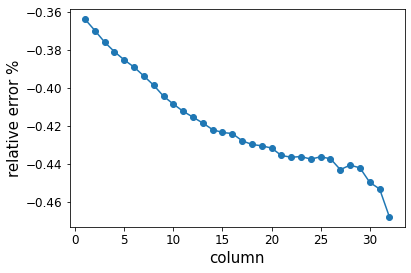

In [137]:
import matplotlib.pyplot as plt
fig = plt.figure()
x = np.arange(1,33)
plt.plot(x,error_mean,marker='o')
plt.xlabel('column',fontsize=15)
plt.ylabel('relative error %',fontsize=15)
plt.tick_params(labelsize=12)
plt.savefig('./mean_error.jpg',bbox_inches='tight')
plt.show()


In [112]:
print(error)

[-0.00185194 -0.00194359 -0.00246236 -0.00248557 -0.00275287 -0.00242498
 -0.00272432 -0.00287051 -0.00303094 -0.00370875 -0.00343995 -0.0032428
 -0.00364708 -0.00446034 -0.00380594 -0.00368618 -0.00372034 -0.00439117
 -0.00366711 -0.00400483 -0.00417812 -0.00404541 -0.00447881 -0.00430748
 -0.00427667 -0.00428389 -0.00430665 -0.00456052 -0.00429727 -0.00426072
 -0.00462061 -0.00462591]


In [107]:
# np.save('normal0.6case_upnode_1ou.npy',up_node)
# np.save('normal0.6case_down_node_1ou_.npy',down_node)
np.save('normal100case_vrram_1ou.npy',V_rram)

In [106]:
print(V_rram)

[[9.86166049e-04 1.12884432e-03 1.63479833e-03 ... 1.64628275e-02
  9.27269738e-03 1.30026465e-02]
 [1.06848619e-03 1.27520943e-03 1.85030481e-03 ... 1.91829383e-02
  1.19646717e-02 1.57965231e-02]
 [1.01867319e-03 1.17985692e-03 1.67487124e-03 ... 2.45439517e-02
  1.73100690e-02 2.15870208e-02]
 ...
 [7.60059852e-01 7.12484398e-01 6.74442094e-01 ... 2.05326071e-03
  1.80424784e-03 1.98746510e-03]
 [8.12104638e-01 7.50554863e-01 7.15381157e-01 ... 1.45822274e-03
  1.29143038e-03 1.40345094e-03]
 [8.69956964e-01 8.16395761e-01 7.84240106e-01 ... 8.43598884e-04
  7.67201690e-04 8.30211988e-04]]


In [14]:
a = np.ones(5)
b = -a
tt = np.vstack((a,b))
tt.T.reshape(10)

array([ 1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.])